# Linear Regression

## Import libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, ElasticNetCV, ElasticNet
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Data imputation
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, KFold

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

import dengue_utils as dutils

import xgboost as xgb

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Functions:

def simple_linear_regression(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=83)
    
    reg = LinearRegression(normalize=True).fit(X_train, y_train)

    y_pred = reg.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ex_var = explained_variance_score(y_test, y_pred)
    
    return mae, r2, ex_var

def enet(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=83)

    reg = ElasticNet(normalize=False).fit(X_train, y_train)

    y_pred = reg.predict(X_test)
    
    return y_pred, y_test

def get_metrics(y_test, y_pred):
    
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    ex_var = explained_variance_score(y_test, y_pred)
    
    return mae, r2, ex_var

def feature_engineering(df):## Add month of the year

    print("1. Including month of the year from 'week_start_date....'")
    
    if 'week_start_date' in df.columns:
        df['week_start_date'] = pd.to_datetime(df['week_start_date'])
        df['monthofyear'] = df['week_start_date'].apply(lambda x: x.month)
        
        df = df.drop(['week_start_date'], axis=1)

    # High correlation between ndvi_nw-ndvi-ne and ndvi-sw-ndvi-se
    # Add the mean of each pair that indicates the level of vegetation in the north and south of both cities.

    # Features engineering
    print("2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... ")
    
    if 'ndvi_nw' in df.columns and 'ndvi_ne' in df.columns and 'ndvi_sw' in df.columns and 'ndvi_se' in df.columns:
    
        df['ndvi_north'] = df[['ndvi_nw', 'ndvi_ne']].mean(axis=1)
        df['ndvi_south'] = df[['ndvi_sw', 'ndvi_se']].mean(axis=1)
        
        df = df.drop(['ndvi_sw', 'ndvi_nw', 'ndvi_ne', 'ndvi_se'], axis=1)

    # Conversion kelvin to celsius
    print("3. Temperature units conversion: kelvin to celsius from some features...")
    df = dutils.temperature_conversion(df)
    
    # Drop temperature features
   # df = df.drop(['reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c', 
   #               'reanalysis_max_air_temp_c', 'reanalysis_min_air_temp_c',
   #               'reanalysis_avg_temp_c', 'reanalysis_tdtr_c', 'station_max_temp_c',
   #               'station_max_temp_c', 'station_diur_temp_rng_c', 'station_avg_temp_c',
   #              'station_min_temp_c', 'reanalysis_specific_humidity_g_per_kg'], axis=1)
   # 
    return df


In [3]:
# Load dataset

features_train = pd.read_csv('dengue_features_train.csv')
labels_train   = pd.read_csv('dengue_labels_train.csv')

features_test = pd.read_csv('dengue_features_test.csv')

# Join train labes and features
input_train_dataset = features_train.merge(labels_train, 
                                           left_on = ['city', 'year', 'weekofyear'], 
                                           right_on = ['city', 'year', 'weekofyear'],
                                           how = 'inner')



## Preprocessing

In [4]:
train_dataset_city = input_train_dataset[input_train_dataset['city'].isin(["iq", "sj"])]

def preprocessing(dataset, train=True):
    # --------------------------------------
    # Feature engineering
    #---------------------------------------

    dataset = feature_engineering(dataset)
    label = 'total_cases'

    # --------------------------------------
    # Remove outiers
    #---------------------------------------

    # Remove outliers
    for feature in  dataset.columns:
        dataset[feature] = dutils.remove_outliers_iqr(dataset, feature, exclude = ['total_cases'])

    dutils.printlog("Remove outliers " + str(dataset.shape)) 
    # Filling the outliers gaps
    #dataset = dataset.dropna().drop_duplicates()

    # --------------------------------------
    # Split data and label
    #---------------------------------------
    
    if train:
        # Split label and features
        dataset_label  = dataset[label]
        dataset = dataset.drop([label], axis=1)

        
        
    # Drop city column because is not numeric and label column (total_cases)
    features_lreg = dataset.columns.drop(['city'])

    dataset = dataset[features_lreg]


    # --------------------------------------
    # Scaling and data imputation
    #---------------------------------------

    # Data imputation
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
    dataset_train_imp = pd.DataFrame(imp.fit_transform(dataset))

    dutils.printlog("Data imputation " + str(dataset.shape)) 
    
    # Set columns name
    dataset_train_imp.columns = dataset.columns
    dataset_train_imp.index   = dataset.index


    # Scale data (features)
    scaler = StandardScaler().fit(dataset_train_imp)
    dataset = pd.DataFrame(scaler.transform(dataset_train_imp), 
                           columns = dataset_train_imp.columns)

    dutils.printlog("Scale " + str(dataset.shape)) 
    
    if train:
        dataset[label] = dataset_label
    
    return dataset



In [5]:
dutils.printlog("Preprocessing " + str(train_dataset_city.shape)) 
dataset_train = preprocessing(train_dataset_city)
dataset_train.describe().T

dataset_label = dataset_train['total_cases']
dataset_train = dataset_train.drop(['total_cases'], axis=1)

20190414 - 11:M:02: Preprocessing (1456, 25)
1. Including month of the year from 'week_start_date....'
2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... 
3. Temperature units conversion: kelvin to celsius from some features...
20190414 - 11:M:02: Temperature conversion: kelvin to celsius reanalysis_air_temp_k to reanalysis_air_temp_c
20190414 - 11:M:02: Temperature conversion: kelvin to celsius reanalysis_dew_point_temp_k to reanalysis_dew_point_temp_c
20190414 - 11:M:02: Temperature conversion: kelvin to celsius reanalysis_max_air_temp_k to reanalysis_max_air_temp_c
20190414 - 11:M:02: Temperature conversion: kelvin to celsius reanalysis_min_air_temp_k to reanalysis_min_air_temp_c
20190414 - 11:M:02: Temperature conversion: kelvin to celsius reanalysis_avg_temp_k to reanalysis_avg_temp_c
20190414 - 11:M:02: Temperature conversion: kelvin to celsius reanalysis_tdtr_k to reanalysis_tdtr_c
20190414 - 11:M:02: Remove outliers (1456, 23)
20190414 - 11:M:02

## Training models

(18.61676764630326, 0.18072559514667874, 0.1810087801955732)
(14.46330696965487, 0.44723056108773207, 0.4517057096330265)
(15.001302993700143, 0.38843344639645483, 0.3930896181799275)
(11.54984825961802, 0.7385597002611785, 0.7398751338220031)


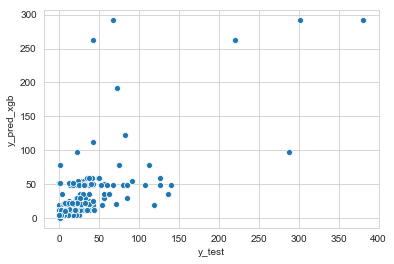

In [6]:
# --------------------------------------
# Split dataset in test and training
#---------------------------------------
X_train, X_test, y_train, y_test = train_test_split(dataset_train, 
                                                    dataset_label, 
                                                    test_size = 0.2, 
                                                    random_state=83)

# --------------------------------------
# Training models
#---------------------------------------

# Elastic Net
enet   = ElasticNet(normalize = False).fit(X_train, y_train)
y_pred_enet = enet.predict(X_test)

metrics_enet = get_metrics(y_test, y_pred_enet)
print(metrics_enet)

# Decision Tree
tree_reg   = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)
y_pred_tree = tree_reg.predict(X_test)

metrics_tree = get_metrics(y_test, y_pred_tree)
print(metrics_tree)

#Ensemble
ensemble_reg = GradientBoostingRegressor(max_depth=5, n_estimators=5, learning_rate=1.0, random_state = 83)
ensemble_reg = ensemble_reg.fit(X_train, y_train)
y_pred_ensemble = ensemble_reg.predict(X_test)

metrics_ensemble = get_metrics(y_test, y_pred_ensemble)
print(metrics_ensemble)

#XGBoost

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=83)
xgb_model = xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

metrics_xgb = get_metrics(y_test, y_pred_xgb)
print(metrics_xgb)

df_test = pd.DataFrame(list(y_test), columns=['y_test'])
y_pred_xgb = pd.DataFrame(list(y_pred_tree), columns=['y_pred_xgb'])

df = pd.concat([df_test, y_pred_xgb], axis=1)


ax = sns.scatterplot(x="y_test", y="y_pred_xgb", data=df)

In [8]:
## Prepare submision

In [10]:
# Save predictions
dutils.printlog("Preprocessing " + str(features_test.shape)) 
dataset_test = preprocessing(features_test, train=False)
dataset_test.describe().T

y_predictions = xgb_model.predict(dataset_test)
features_test['total_cases'] = np.round(y_predictions).astype(int)

20190414 - 11:M:17: Preprocessing (416, 25)
1. Including month of the year from 'week_start_date....'
2. Including ndvi_north and  ndvi_south from ndvi_nw, ndvi_ne, ndvi_sw, ndvi_se.... 
3. Temperature units conversion: kelvin to celsius from some features...
20190414 - 11:M:17: Temperature conversion: kelvin to celsius reanalysis_air_temp_k to reanalysis_air_temp_c
20190414 - 11:M:17: Temperature conversion: kelvin to celsius reanalysis_dew_point_temp_k to reanalysis_dew_point_temp_c
20190414 - 11:M:17: Temperature conversion: kelvin to celsius reanalysis_max_air_temp_k to reanalysis_max_air_temp_c
20190414 - 11:M:17: Temperature conversion: kelvin to celsius reanalysis_min_air_temp_k to reanalysis_min_air_temp_c
20190414 - 11:M:17: Temperature conversion: kelvin to celsius reanalysis_avg_temp_k to reanalysis_avg_temp_c
20190414 - 11:M:17: Temperature conversion: kelvin to celsius reanalysis_tdtr_k to reanalysis_tdtr_c
20190414 - 11:M:17: Remove outliers (416, 22)
20190414 - 11:M:17: 

In [11]:
features_test.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,monthofyear,total_cases
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2,4,20
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3,5,23
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0,5,21
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3,5,26
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1,5,20


In [13]:
features_test[['city', 'year', 'weekofyear', 'total_cases']].to_csv("./submission_20190414.csv", index=False)

# Submision score : 39.5072